In [32]:
#!pip install pylabel
#!pip install utils

In [1]:
# import
import os
import sys
from PIL import Image
import time
import numpy as np
import random
from pylabel import importer
import glob, json, os, shutil
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pprint import pprint
import glob, json
import torch
import utils
from glob import glob
from sklearn.model_selection import train_test_split

# 0. 데이터 생성  
---

In [2]:
file_list = os.listdir('./TrainingData/data/Images/')
# img_random=random.sample(file_list, 100)
#img_random.save('./Dataset/', format='PNG')
# img_random

# 1. 데이터 전처리 
## 1-1) Image Compression  
---

In [3]:
def change_img_qualty(original_path, change_path, qualty):
    """
    Change Image Qualty
    :param original_path: 원본 경로
    :param change_path: 변경 후 새롭게 저장될 경로
    :param qualty: Qualty(품질) 퍼센트(기본 : 85%)
    :return:
    """
    if not os.path.exists(change_path):
        os.mkdir(change_path)
    try:
        ims_list = os.listdir(original_path)
        ims_list.sort()
    except FileNotFoundError as e:
        print("이미지 원본 디렉터리가 존재하지 않습니다...")
        sys.exit(0)
    success_cnt = 0
    fail_cnt = 0
    for filename in ims_list:
        file = original_path + filename
        try:
            im = Image.open(file)
            im.save(os.path.join(change_path, filename), qualty=qualty)
            print("+ 성공 : {success}\n  "
                  "- {success_path}"
                  .format(success=file, success_path=os.path.join(change_path, filename))
                  )
            success_cnt += 1
        except Exception as e:
            print("+ 실패 : {fail}".format(fail=file))
            fail_cnt += 1
    print("\n성공 : {success_cnt} 건 / 실패 : {fail_cnt} 건".format(success_cnt=success_cnt, fail_cnt=fail_cnt))
    sys.exit(0)

In [4]:
# if __name__ == '__main__':
#     original_path = './TrainingData/data/Images/'
#     change_path = './TrainingData/data/change_img/'
#     change_img_qualty(original_path, change_path,85)

## 1-2) Category Equalization
## 1-3) Convert COCO to YOLO
## 1-4) Convert json to txt
---

In [5]:
# annotation 폴더 내의 json 파일 불러오기
LABEL_PATH = './TrainingData/data/Annotations/'
IMAGE_PATH = './TrainingData/data/Images/'
LABEL_SAVE_PATH = './TrainingData/data/equalized_label'
IMAGE_SAVE_PATH = './TrainingData/data/equalized_img'
json_list = os.listdir(LABEL_PATH)
img_list = os.listdir(IMAGE_PATH)

In [6]:
cat_1 = 0  # Animals(Dolls)                                    delete
cat_2 = 0  # Person
cat_3 = 0  # Garbage bag & sacks
cat_4 = 0  # Construction signs & Parking prohibited board
cat_5 = 0  # Traffic cone
cat_6 = 0  # Box                                               delete
cat_7 = 0  # Stones on road                                    delete
cat_8 = 0  # Pothole on road
cat_9 = 0  # Filled pothole
cat_10 = 0  # Manhole
cat_list = ["Animals(Dolls)", "Person", "Garbage bag & sacks", "Construction signs & Parking prohibited board",
            "Traffic cone",
            "Box", "Stones on road", "Pothole on road", "Filled pothole", "Manhole"]

In [7]:
for file in json_list:
    # pylabel load
    dataset = importer.ImportCoco(LABEL_PATH + file)

    for i in range(len(dataset.df)):
        # if 라벨이 하나만 있을 때
        if len(dataset.df) == 1:
            # 이미지 복사를 위한 변수들
            cat_id = dataset.df.iloc[i].cat_id
            img_name = dataset.df.iloc[i].img_filename

            # txt 변경을 위한 변수들
            img_name2 = dataset.df.iloc[i].img_filename[:-3]
            bbox_x = dataset.df.iloc[i].ann_bbox_xmin
            bbox_y = dataset.df.iloc[i].ann_bbox_ymin
            height = dataset.df.iloc[i].ann_bbox_height
            width = dataset.df.iloc[i].ann_bbox_width
            img_height = dataset.df.iloc[i].img_height
            img_width = dataset.df.iloc[i].img_width
            img_category = int(dataset.df.iloc[i].cat_id) - 1

            if int(cat_id) == 2 and cat_2 <= 100:
                # ------------------- 이미지 복사 부분 -------------------
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(IMAGE_SAVE_PATH + cat_id):
                    os.makedirs(IMAGE_SAVE_PATH + cat_id)
                else:
                    pass
                # 파일을 새로운 경로로 복사한다.
                shutil.copy2(IMAGE_PATH + img_name, IMAGE_SAVE_PATH + cat_id + '/' + img_name)
                # ------------------------------------------------------

                # -------------------- 라벨 생성 부분 --------------------
                if img_height == 0:
                    img_height = 720
                else:
                    pass
                if img_width == 0:
                    img_width = 1280
                else:
                    pass

                dw = 1.0 / img_width
                dh = 1.0 / img_height

                x_center = bbox_x + width / 2.0
                y_center = bbox_y + height / 2.0

                x = x_center * dw
                y = y_center * dh
                w = width * dw
                h = height * dh
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(LABEL_SAVE_PATH + cat_id):
                    os.makedirs(LABEL_SAVE_PATH + cat_id)
                else:
                    pass

                # 파일이 있으면
                if os.path.isfile(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt'):
                    pass
                # 파일이 없으면
                else:
                    f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'w')
                    f.close()

                f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'a')
                f.write(str(img_category) + ' ')
                f.write(str(x) + ' ')
                f.write(str(y) + ' ')
                f.write(str(w) + ' ')
                f.write(str(h) + '\n')
                f.close()
                # ------------------------------------------------------

                # 카테고리 카운팅
                cat_2 += 1

            if int(cat_id) == 3 and cat_3 <= 100:
                # ------------------- 이미지 복사 부분 -------------------
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(IMAGE_SAVE_PATH + cat_id):
                    os.makedirs(IMAGE_SAVE_PATH + cat_id)
                else:
                    pass
                # 파일을 새로운 경로로 복사한다.
                shutil.copy2(IMAGE_PATH + img_name, IMAGE_SAVE_PATH + cat_id + '/' + img_name)
                # ------------------------------------------------------

                # -------------------- 라벨 생성 부분 --------------------
                if img_height == 0:
                    img_height = 720
                else:
                    pass
                if img_width == 0:
                    img_width = 1280
                else:
                    pass

                dw = 1.0 / img_width
                dh = 1.0 / img_height

                x_center = bbox_x + width / 2.0
                y_center = bbox_y + height / 2.0

                x = x_center * dw
                y = y_center * dh
                w = width * dw
                h = height * dh
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(LABEL_SAVE_PATH + cat_id):
                    os.makedirs(LABEL_SAVE_PATH + cat_id)
                else:
                    pass

                # 파일이 있으면
                if os.path.isfile(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt'):
                    pass
                # 파일이 없으면
                else:
                    f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'w')
                    f.close()

                f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'a')
                f.write(str(img_category) + ' ')
                f.write(str(x) + ' ')
                f.write(str(y) + ' ')
                f.write(str(w) + ' ')
                f.write(str(h) + '\n')
                f.close()
                # ------------------------------------------------------
                # 카테고리 카운팅
                cat_3 += 1
            if int(cat_id) == 4 and cat_4 <= 100:
                # ------------------- 이미지 복사 부분 -------------------
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(IMAGE_SAVE_PATH + cat_id):
                    os.makedirs(IMAGE_SAVE_PATH + cat_id)
                else:
                    pass
                # 파일을 새로운 경로로 복사한다.
                shutil.copy2(IMAGE_PATH + img_name, IMAGE_SAVE_PATH + cat_id + '/' + img_name)
                # ------------------------------------------------------

                # -------------------- 라벨 생성 부분 --------------------
                if img_height == 0:
                    img_height = 720
                else:
                    pass
                if img_width == 0:
                    img_width = 1280
                else:
                    pass

                dw = 1.0 / img_width
                dh = 1.0 / img_height

                x_center = bbox_x + width / 2.0
                y_center = bbox_y + height / 2.0

                x = x_center * dw
                y = y_center * dh
                w = width * dw
                h = height * dh
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(LABEL_SAVE_PATH + cat_id):
                    os.makedirs(LABEL_SAVE_PATH + cat_id)
                else:
                    pass

                # 파일이 있으면
                if os.path.isfile(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt'):
                    pass
                # 파일이 없으면
                else:
                    f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'w')
                    f.close()

                f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'a')
                f.write(str(img_category) + ' ')
                f.write(str(x) + ' ')
                f.write(str(y) + ' ')
                f.write(str(w) + ' ')
                f.write(str(h) + '\n')
                f.close()
                # ------------------------------------------------------
                # 카테고리 카운팅
                cat_4 += 1
            if int(cat_id) == 5 and cat_5 <= 100:
                # ------------------- 이미지 복사 부분 -------------------
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(IMAGE_SAVE_PATH + cat_id):
                    os.makedirs(IMAGE_SAVE_PATH + cat_id)
                else:
                    pass
                # 파일을 새로운 경로로 복사한다.
                shutil.copy2(IMAGE_PATH + img_name, IMAGE_SAVE_PATH + cat_id + '/' + img_name)
                # ------------------------------------------------------

                # -------------------- 라벨 생성 부분 --------------------
                if img_height == 0:
                    img_height = 720
                else:
                    pass
                if img_width == 0:
                    img_width = 1280
                else:
                    pass

                dw = 1.0 / img_width
                dh = 1.0 / img_height

                x_center = bbox_x + width / 2.0
                y_center = bbox_y + height / 2.0

                x = x_center * dw
                y = y_center * dh
                w = width * dw
                h = height * dh
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(LABEL_SAVE_PATH + cat_id):
                    os.makedirs(LABEL_SAVE_PATH + cat_id)
                else:
                    pass

                # 파일이 있으면
                if os.path.isfile(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt'):
                    pass
                # 파일이 없으면
                else:
                    f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'w')
                    f.close()

                f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'a')
                f.write(str(img_category) + ' ')
                f.write(str(x) + ' ')
                f.write(str(y) + ' ')
                f.write(str(w) + ' ')
                f.write(str(h) + '\n')
                f.close()
                # ------------------------------------------------------
                # 카테고리 카운팅
                cat_5 += 1
            if int(cat_id) == 8 and cat_8 <= 100:
                # ------------------- 이미지 복사 부분 -------------------
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(IMAGE_SAVE_PATH + cat_id):
                    os.makedirs(IMAGE_SAVE_PATH + cat_id)
                else:
                    pass
                # 파일을 새로운 경로로 복사한다.
                shutil.copy2(IMAGE_PATH + img_name, IMAGE_SAVE_PATH + cat_id + '/' + img_name)
                # ------------------------------------------------------

                # -------------------- 라벨 생성 부분 --------------------
                if img_height == 0:
                    img_height = 720
                else:
                    pass
                if img_width == 0:
                    img_width = 1280
                else:
                    pass

                dw = 1.0 / img_width
                dh = 1.0 / img_height

                x_center = bbox_x + width / 2.0
                y_center = bbox_y + height / 2.0

                x = x_center * dw
                y = y_center * dh
                w = width * dw
                h = height * dh
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(LABEL_SAVE_PATH + cat_id):
                    os.makedirs(LABEL_SAVE_PATH + cat_id)
                else:
                    pass

                # 파일이 있으면
                if os.path.isfile(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt'):
                    pass
                # 파일이 없으면
                else:
                    f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'w')
                    f.close()

                f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'a')
                f.write(str(img_category) + ' ')
                f.write(str(x) + ' ')
                f.write(str(y) + ' ')
                f.write(str(w) + ' ')
                f.write(str(h) + '\n')
                f.close()
                # ------------------------------------------------------
                # 카테고리 카운팅
                cat_8 += 1
            if int(cat_id) == 9 and cat_9 <= 100:
                # ------------------- 이미지 복사 부분 -------------------
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(IMAGE_SAVE_PATH + cat_id):
                    os.makedirs(IMAGE_SAVE_PATH + cat_id)
                else:
                    pass
                # 파일을 새로운 경로로 복사한다.
                shutil.copy2(IMAGE_PATH + img_name, IMAGE_SAVE_PATH + cat_id + '/' + img_name)
                # ------------------------------------------------------

                # -------------------- 라벨 생성 부분 --------------------
                if img_height == 0:
                    img_height = 720
                else:
                    pass
                if img_width == 0:
                    img_width = 1280
                else:
                    pass

                dw = 1.0 / img_width
                dh = 1.0 / img_height

                x_center = bbox_x + width / 2.0
                y_center = bbox_y + height / 2.0

                x = x_center * dw
                y = y_center * dh
                w = width * dw
                h = height * dh
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(LABEL_SAVE_PATH + cat_id):
                    os.makedirs(LABEL_SAVE_PATH + cat_id)
                else:
                    pass

                # 파일이 있으면
                if os.path.isfile(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt'):
                    pass
                # 파일이 없으면
                else:
                    f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'w')
                    f.close()

                f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'a')
                f.write(str(img_category) + ' ')
                f.write(str(x) + ' ')
                f.write(str(y) + ' ')
                f.write(str(w) + ' ')
                f.write(str(h) + '\n')
                f.close()
                # ------------------------------------------------------
                # 카테고리 카운팅
                cat_9 += 1
            if int(cat_id) == 10 and cat_10 <= 100:
                # ------------------- 이미지 복사 부분 -------------------
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(IMAGE_SAVE_PATH + cat_id):
                    os.makedirs(IMAGE_SAVE_PATH + cat_id)
                else:
                    pass
                # 파일을 새로운 경로로 복사한다.
                shutil.copy2(IMAGE_PATH + img_name, IMAGE_SAVE_PATH + cat_id + '/' + img_name)
                # ------------------------------------------------------

                # -------------------- 라벨 생성 부분 --------------------
                if img_height == 0:
                    img_height = 720
                else:
                    pass
                if img_width == 0:
                    img_width = 1280
                else:
                    pass

                dw = 1.0 / img_width
                dh = 1.0 / img_height

                x_center = bbox_x + width / 2.0
                y_center = bbox_y + height / 2.0

                x = x_center * dw
                y = y_center * dh
                w = width * dw
                h = height * dh
                # 폴더가 없으면 폴더 생성
                if not os.path.exists(LABEL_SAVE_PATH + cat_id):
                    os.makedirs(LABEL_SAVE_PATH + cat_id)
                else:
                    pass

                # 파일이 있으면
                if os.path.isfile(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt'):
                    pass
                # 파일이 없으면
                else:
                    f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'w')
                    f.close()

                f = open(LABEL_SAVE_PATH + cat_id + '/' + img_name2 + 'txt', 'a')
                f.write(str(img_category) + ' ')
                f.write(str(x) + ' ')
                f.write(str(y) + ' ')
                f.write(str(w) + ' ')
                f.write(str(h) + '\n')
                f.close()
                # ------------------------------------------------------
                # 카테고리 카운팅
                cat_10 += 1
        else:
            pass

In [8]:
cat_count = [cat_1, cat_2, cat_3, cat_4, cat_5,
             cat_6, cat_7, cat_8, cat_9, cat_10]

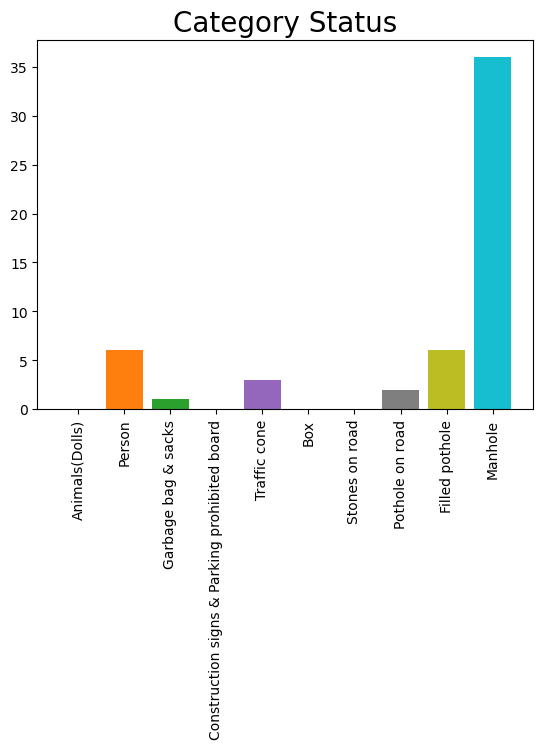

In [9]:
plt.title("Category Status", size=20)
plt.bar(cat_list, cat_count, color=mcolors.TABLEAU_COLORS)
plt.xticks(rotation=90)
plt.show()

# 2. Create yaml
---

In [10]:
# 이미지 파일 리스트 생성
train_img_list = glob(r'./TrainingData/data/change_img/*.png')
print(f'Image 갯수: {len(train_img_list)}')

Image 갯수: 100


In [11]:
# train, validation 데이터 분리
train_img_list, val_img_list = train_test_split(train_img_list,
                                                  train_size=0.8,
                                                  random_state=42)

print(f'Train Image 갯수: {len(train_img_list)}')
print(f'Validation Image 갯수: {len(val_img_list)}')

Train Image 갯수: 80
Validation Image 갯수: 20


In [12]:
# train/val 이미지 경로 txt파일로 저장
with open(r'C:\Users\USER\T3Q_1_project\TrainingData\train.txt', 'w') as f:
    f.write('\n'.join(train_img_list) + '\n')

with open(r'C:\Users\USER\T3Q_1_project\TrainingData\val.txt', 'w') as f:
    f.write('\n'.join(val_img_list) + '\n')

In [13]:
# ymal 파일 정보 확인
import yaml

with open(r'C:\Users\USER\T3Q_1_project\TrainingData\data.yaml', 'r') as f:
    data = yaml.full_load(f)

print(f'data.yaml 파일 정보: {data}')

data['train'] = r'C:\Users\USER\T3Q_1_project\TrainingData\train.txt'
data['val'] = r'C:\Users\USER\T3Q_1_project\TrainingData\val.txt'

with open(r'C:\Users\USER\T3Q_1_project\TrainingData\data.yaml', 'w') as f:
    yaml.dump(data, f)

print(data)

data.yaml 파일 정보: {'names': ['Animals(Dolls)', 'Person', 'Garbage bag & sacks', 'Construction signs & Parking prohibited board', 'Traffic cone', 'Box', 'Stones on road', 'Pothole on road', 'Filled pothole', 'Manhole'], 'nc': 10, 'train': 'C:\\Users\\USER\\T3Q_1_project\\TrainingData\\train.txt', 'val': 'C:\\Users\\USER\\T3Q_1_project\\TrainingData\\val.txt'}
{'names': ['Animals(Dolls)', 'Person', 'Garbage bag & sacks', 'Construction signs & Parking prohibited board', 'Traffic cone', 'Box', 'Stones on road', 'Pothole on road', 'Filled pothole', 'Manhole'], 'nc': 10, 'train': 'C:\\Users\\USER\\T3Q_1_project\\TrainingData\\train.txt', 'val': 'C:\\Users\\USER\\T3Q_1_project\\TrainingData\\val.txt'}


# 3. YOLOv5  
---

In [14]:
#!git clone https://github.com/knudatascientists/T3Q_projects_team_1/tree/main/yolo_v5/yolov5-master  # clone

In [15]:
%cd C://project/T3Q_projects_team_1/yolo_v5/yolov5-master

C:\project\T3Q_projects_team_1\yolo_v5\yolov5-master


In [16]:
#%pip install -qr requirements.txt 

In [17]:
#!python train.py --batch 16 --epochs 50 --data C://Users/USER/T3Q_1_project/TrainingData/data.yaml  --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name T3Q_yolov5s_results

In [18]:
!python detect.py --weights C://Users/USER/T3Q_1_project/TrainingData/train_results/weights/best.pt --img 416 --conf 0.5 --source "https://www.youtube.com/watch?v=pIfB4sTGO-c"

^C
